출처<br>[전체](https://medium.com/@nissanttiwari/santander-customer-satisfaction-82eacb41a2b3) <br> 
[특성 고르기](https://www.kaggle.com/code/solegalli/feature-selection-with-feature-engine/notebook#Table-of-Contents)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np # 넘파이
import pandas as pd # 판다스
import sklearn #사이킷런
import matplotlib.pyplot as plt #그래프1
import seaborn as sns  # 그래프2
from sklearn.ensemble import RandomForestClassifier # 모델1
from sklearn.linear_model import LogisticRegression  # 모델2
from sklearn.metrics import roc_auc_score #성능평가
from sklearn.model_selection import train_test_split, cross_validate #데이터분리, 교차검증
from sklearn.pipeline import Pipeline #파이프라인
from sklearn.preprocessing import StandardScaler #스케일링

In [4]:
!pip install feature-engine # 특성 추출 모듈 

     |████████████████████████████████| 205 kB 4.1 MB/s 
     |████████████████████████████████| 9.8 MB 32.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [5]:
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
    DropDuplicateFeatures,
    DropCorrelatedFeatures,
    SmartCorrelatedSelection,
    SelectByShuffling,
    SelectBySingleFeaturePerformance,
    RecursiveFeatureElimination,
)

In [10]:
train_df = pd.read_csv('/content/drive/MyDrive/DATA/Santander Customer Satisfaction_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/DATA/Santander Customer Satisfaction_test.csv') 

In [62]:
train_df.shape, test_df.shape

((76020, 370), (75818, 369))

In [11]:
train_id= train_df['ID']
test_id= test_df['ID']

train_df.drop(['ID'], axis=1, inplace= True)
test_df.drop(['ID'], axis=1, inplace= True)

In [21]:
y_train= train_df['TARGET']
X_train= train_df.drop('TARGET', axis=1)
X_test = test_df

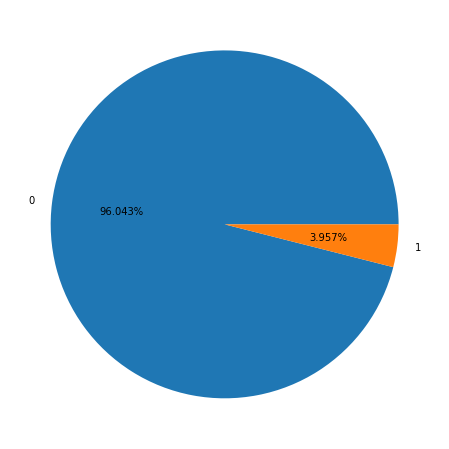

Number of Positive data points are: 3008  (3.957%)
Number of Negative data points are: 73012 (96.043%)


In [12]:
zero= train_df['TARGET'].value_counts()[0]
one= train_df['TARGET'].value_counts()[1]
my_labels=[0,1]
plt.rcParams["figure.figsize"] = (8,8)

plt.pie([zero,one], labels= my_labels, autopct='%1.3f%%')
plt.show()

print("Number of Positive data points are: {}  ({:.3f}{})".format(one, one/(one+zero)*100, "%"))
print("Number of Negative data points are: {} ({:.3f}{})".format(zero, zero/(one+zero)*100, "%"))

## 일정한 데이터로된 컬럼 거르기
- 38개

In [22]:
# with tol=1 we tell the transformer to remove constant features
constant = DropConstantFeatures(tol=1)

# finds the constant features on the train set
constant.fit(X_train)

DropConstantFeatures()

In [ ]:
len(constant.features_to_drop_)

38

In [23]:
print('Number of variables before removing constant: ', X_train.shape[1])

Number of variables before removing constant:  369


In [24]:
# remove constant features - transform method
X_train = constant.transform(X_train)
X_test = constant.transform(X_test)

print('Number of variables after removing constant: ', X_train.shape[1])

Number of variables after removing constant:  335


In [17]:
X_train.shape, X_test.shape

(76020, 335)

## 거의 일정한 데이터 삭제 
- 139개

In [25]:
quasi_constant = DropConstantFeatures(tol=0.9995)
# find quasi-constant features in the train set
quasi_constant.fit(X_train)

DropConstantFeatures(tol=0.9995)

In [ ]:
print('Number of variables before removing quasi-constant: ', X_train.shape[1])

Number of variables before removing quasi-constant:  331


In [26]:
# remove quasi-constant features - transform method
X_train = quasi_constant.transform(X_train)
X_test = quasi_constant.transform(X_test)

print('Number of variables after removing quasi-constant: ', X_train.shape[1])

Number of variables after removing quasi-constant:  242


In [27]:
X_train.shape, X_test.shape

((76020, 242), (75818, 242))

## 중복값 삭제

In [28]:
duplicates = DropDuplicateFeatures()

# find duplicated features in the train set
duplicates.fit(X_train)

DropDuplicateFeatures()

In [29]:
duplicates.duplicated_feature_sets_ #중복값 특성들 나열

[{'ind_var26', 'ind_var26_0'},
 {'ind_var25', 'ind_var25_0'},
 {'ind_var32', 'ind_var32_0'},
 {'ind_var37', 'ind_var37_0'},
 {'ind_var39', 'ind_var40'},
 {'num_var26', 'num_var26_0'},
 {'num_var25', 'num_var25_0'},
 {'num_var32', 'num_var32_0'},
 {'num_var37', 'num_var37_0'},
 {'num_var39', 'num_var40'}]

In [30]:
X_train['ind_var26'].equals(X_train['ind_var26_0']) # 100프로 중복 

True

In [31]:
duplicates.features_to_drop_

{'ind_var25',
 'ind_var26',
 'ind_var32',
 'ind_var37',
 'ind_var39',
 'num_var25',
 'num_var26',
 'num_var32',
 'num_var37',
 'num_var39'}

In [ ]:
print('Number of variables before removing duplicates: ', X_train.shape[1])

Number of variables before removing duplicates:  242


In [32]:
X_train = duplicates.transform(X_train)
X_test = duplicates.transform(X_test)

print('Number of variables after removing duplicates: ', X_train.shape[1])

Number of variables after removing duplicates:  232


In [33]:
X_train.shape, X_test.shape

((76020, 232), (75818, 232))

## 상관관계 
- 103개

In [34]:
correlated = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.98)

# find correlated variables in the train set
correlated.fit(X_train)

DropCorrelatedFeatures(threshold=0.98)

In [38]:
correlated.correlated_feature_sets_

[{'imp_op_var39_efect_ult1', 'imp_op_var41_efect_ult1'},
 {'imp_op_var39_efect_ult3', 'imp_op_var41_efect_ult3'},
 {'imp_op_var39_ult1', 'imp_op_var41_ult1'},
 {'ind_var1_0', 'ind_var40_0', 'num_var1_0', 'num_var40_0'},
 {'ind_var1', 'ind_var40', 'num_var1', 'num_var40'},
 {'ind_var5', 'num_var5'},
 {'ind_var8_0', 'num_var8_0'},
 {'ind_var8', 'num_var8'},
 {'ind_var12', 'num_var12'},
 {'ind_var13', 'ind_var13_0'},
 {'ind_var13_corto',
  'ind_var13_corto_0',
  'num_var13_corto',
  'num_var13_corto_0'},
 {'ind_var13_largo', 'ind_var13_largo_0'},
 {'ind_var14', 'num_var14'},
 {'ind_var20_0', 'num_var20_0'},
 {'ind_var20', 'num_var20'},
 {'ind_var24_0', 'num_var24_0'},
 {'ind_var24', 'num_var24'},
 {'ind_var39_0', 'ind_var41_0'},
 {'ind_var44_0', 'num_var44_0'},
 {'ind_var44', 'num_var44'},
 {'num_var35', 'num_var4'},
 {'num_op_var39_hace2', 'num_op_var41_hace2'},
 {'num_op_var39_hace3', 'num_op_var41_hace3'},
 {'num_op_var39_ult1', 'num_op_var41_ult1'},
 {'num_op_var39_ult3', 'num_op_var4

In [40]:
corrmat = X_train[[
    'imp_op_var39_comer_ult1',
    'imp_op_var39_comer_ult3',
    'imp_op_var41_comer_ult1',
    'imp_op_var41_comer_ult3']].corr(method='pearson')

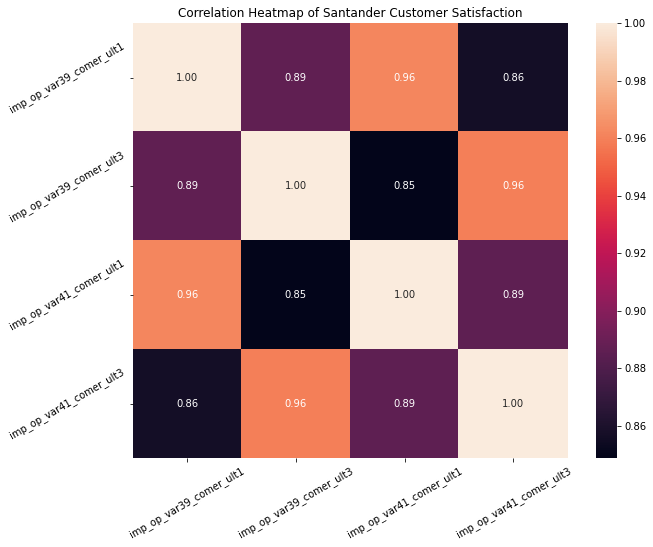

In [41]:
plt.figure(figsize=(10,8))
plt.title('Correlation Heatmap of Santander Customer Satisfaction')
a = sns.heatmap(corrmat, square=True, annot=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()    # 0.8 이상의 상관성을 알 수 있다.

In [43]:
len(correlated.features_to_drop_)

49

In [48]:
print('Number of variables before removing correlated: ', X_train.shape[1])

Number of variables before removing correlated:  183


In [49]:
# remove correlated variables
X_train = correlated.transform(X_train)
X_test = correlated.transform(X_test)

print('Number of variables after removing correlated: ', X_train.shape[1])

ValueError: ignored

In [47]:
X_train.shape, X_test.shape

((76020, 183), (75818, 183))

## 모듈을 이용해 한번더 상관성 파악 후 drop
- 17개

In [ ]:
X_train.shape, X_test.shape

In [65]:
smart_corr = SmartCorrelatedSelection(
    variables=None, # examines all variables
    method="pearson", # the correlation method
    threshold=0.98, # the correlation coefficient threshold
    missing_values="ignore",
    selection_method="model_performance", # how to select the features
    estimator=RandomForestClassifier(n_estimators=10, random_state=1), # the model from which to derive the importance
)

# find correlated features and select the best from each group

# the method builds a random forest using each single feature from the correlated feature group
# and retains the feature from the group with the best performance

smart_corr.fit(X_train, X_test)

SmartCorrelatedSelection(estimator=RandomForestClassifier(n_estimators=10,
                                                          random_state=1),
                         selection_method='model_performance', threshold=0.98)

In [66]:
# the correlated feature groups

smart_corr.correlated_feature_sets_

[]

In [67]:
# lets examine the performace of a random forest based on
# each feature from the fifth group from above, to understand
# what the transformer is doing

# select fifth group of correlated features
group = smart_corr.correlated_feature_sets_[4]

# build random forest with cross validation for
# each feature

for f in group:
    model = cross_validate(
        RandomForestClassifier(n_estimators=10, random_state=1),
        X_train[f].to_frame(),
        y_train,
        cv=3,
        return_estimator=False,
        scoring='roc_auc',
    )

    print(f, model["test_score"].mean())

IndexError: ignored

In [53]:
# this variable will be dropped, and thus it is in the features_to_drop_ attribute
for i in group:
  print(i, i in smart_corr.features_to_drop_)

NameError: ignored

In [54]:
print('Number of variables before removing correlated: ', X_train.shape[1])

Number of variables before removing correlated:  183


In [68]:
# remove correlated variables
X_train = smart_corr.transform(X_train)
X_test = smart_corr.transform(X_test)
print('Number of variables after removing correlated: ', X_train.shape[1])

Number of variables after removing correlated:  183


In [63]:
X_train.shape, X_test.shape

((76020, 183), (75818, 183))

In [58]:
X_train1 = X_train
X_test1 = X_test

In [ ]:
X_train = X_train1
X_test = X_test1

# 1. 파이프라인 형성하기

In [ ]:
# load data again
data = pd.read_csv('/content/drive/MyDrive/DATA/Santander Customer Satisfaction_train.csv')

# separate dataset into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['ID','TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((53214, 369), (22806, 369))

나만의 파이프라인

In [ ]:
def remove_sparse_feats(self, train= train, test= test, threshold= 0.998):
  zeros = (train == 0 ).astype(int).sum()
  not_zeros= (train != 0 ).astype(int).sum()

  sparse_columns=[]

  for i in range(len(train.columns)):
    if (zeros[i]/(zeros[i]+not_zeros[i]) > threshold:
        sparse_columns.append(train.columns[i])
  print('Number of columns before: ', train.shape[1])
  print('Number of columns before: ', teast.shape[1])

  train.drop(sparse_columns, axis=1, inplace=True)
  test.drop(sparse_columns, axis=1, inplace=True)
  print('Number of columns after: ', train.shape[1])
  print('Number of columns after: ', teast.shape[1])



In [ ]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.9995)), # drops constand and quasi-constant altogether
    ('duplicated', DropDuplicateFeatures()), # drops duplicates
    ('correlation', SmartCorrelatedSelection( # drops correlated
        threshold=0.98,
        selection_method="model_performance",
        estimator=RandomForestClassifier(n_estimators=10, random_state=1),
    )),
])
# find features to remove

pipe.fit(X_train, y_train)

Pipeline(steps=[('constant', DropConstantFeatures(tol=0.9995)),
                ('duplicated', DropDuplicateFeatures()),
                ('correlation',
                 SmartCorrelatedSelection(estimator=RandomForestClassifier(n_estimators=10,
                                                                           random_state=1),
                                          selection_method='model_performance',
                                          threshold=0.98))])

In [ ]:
print('Number of original variables: ', X_train.shape[1]) # drop 전 컬럼 수 
print('Number of original variables: ', X_train.shape[1]) # drop 전 컬럼 수 

Number of original variables:  369


In [ ]:
# remove variables
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)


print('Number of variables after selection: ', X_train.shape[1])

Number of variables after selection:  182


In [ ]:
test_pred = pipe.transform(test_pred)

In [ ]:
X_test.shape, X_train.shape, test_pred.shape

((22806, 182), (53214, 182), (75818, 182))

# 1) Shuffling으로 특성 고르기 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['ID','TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

In [ ]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)), # drops constand and quasi-constant altogether
    ('duplicated', DropDuplicateFeatures()),
])

# find features to remove
pipe.fit(X_train, y_train)

# remove variables

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

In [ ]:
shuffle = SelectByShuffling(
    estimator = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=1), # the model
    scoring="roc_auc", # the metric to determine model performance
    cv=3, # the cross-validation fold
)

shuffle.fit(X_train, y_train)

SelectByShuffling(estimator=RandomForestClassifier(max_depth=2, n_estimators=10,
                                                   random_state=1))

In [ ]:
shuffle.initial_model_performance_

0.7675761929904802

In [ ]:
shuffle.performance_drifts_

{'delta_imp_aport_var13_1y3': -0.0039048335433380377,
 'delta_num_aport_var13_1y3': -0.0039048335433380377,
 'imp_aport_var13_hace3': -0.0039048335433380377,
 'imp_aport_var13_ult1': -0.0039048335433380377,
 'imp_ent_var16_ult1': -0.0039048335433380377,
 'imp_op_var39_comer_ult1': -0.0039048335433380377,
 'imp_op_var39_comer_ult3': -0.0039048335433380377,
 'imp_op_var39_efect_ult1': -0.0039048335433380377,
 'imp_op_var39_efect_ult3': -0.002194636699535124,
 'imp_op_var39_ult1': -0.0039048335433380377,
 'imp_op_var40_comer_ult1': -0.0039048335433380377,
 'imp_op_var40_comer_ult3': -0.0039048335433380377,
 'imp_op_var40_ult1': -0.0039048335433380377,
 'imp_op_var41_comer_ult1': -0.0039048335433380377,
 'imp_op_var41_comer_ult3': -0.0040306556876368305,
 'imp_op_var41_efect_ult1': -0.003336295319762761,
 'imp_op_var41_efect_ult3': -0.0003856965949363689,
 'imp_op_var41_ult1': -0.003916347362536765,
 'imp_trans_var37_ult1': -0.003816794475509311,
 'imp_var43_emit_ult1': -0.0039048335433380

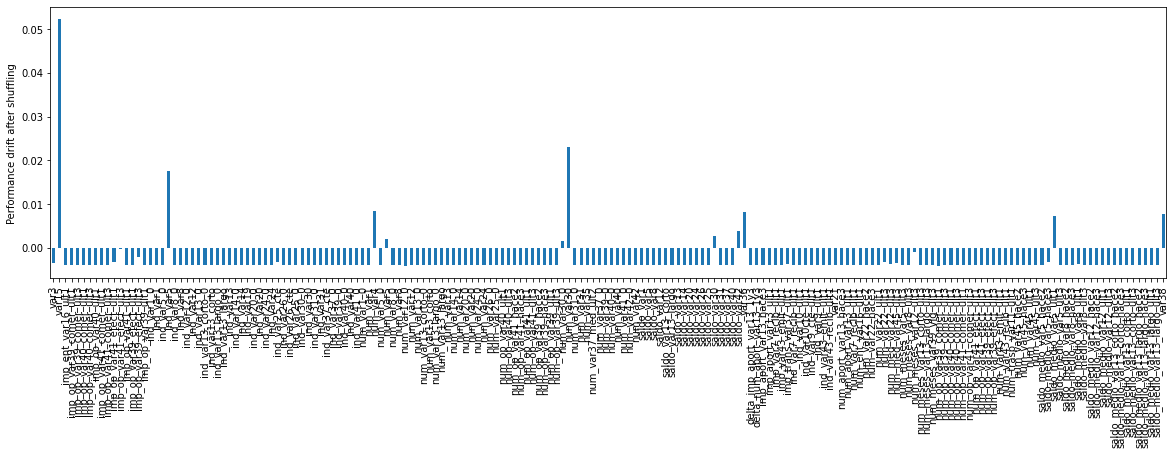

In [ ]:
pd.Series(shuffle.performance_drifts_).plot.bar(figsize=(20,5))
plt.ylabel('Performance drift after shuffling')
plt.show()

In [ ]:
# here we find the attributes that will be dropped

len(shuffle.features_to_drop_)

170

In [ ]:
X_train = shuffle.transform(X_train)
X_test = shuffle.transform(X_test)

print('Number of variables after removing non important: ', X_train.shape[1])

Number of variables after removing non important:  14


In [ ]:
# we can go ahead and train a random forest using the selected features and evaluate
# its performance

rf = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=1)

rf.fit(X_train, y_train)

pred = rf.predict_proba(X_train)
print('Train roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))

pred = rf.predict_proba(X_test)
print('Test roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Train roc-auc: 0.7987048798415026
Test roc-auc: 0.7956725896493668


# 2) 일변양으로 특성 고르기

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['ID','TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)), # drops constand and quasi-constant altogether
    ('duplicated', DropDuplicateFeatures()),
])

# find features to remove
pipe.fit(X_train, y_train)

# remove variables

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

In [ ]:
sel = SelectBySingleFeaturePerformance(
    estimator = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=1), # the model
    scoring="roc_auc", # the metric to determine model performance
    cv=3, # the cross-validation fold,
    threshold=None, # the performance threshold
)

sel.fit(X_train, y_train)

SelectBySingleFeaturePerformance(estimator=RandomForestClassifier(max_depth=2,
                                                                  n_estimators=10,
                                                                  random_state=1))

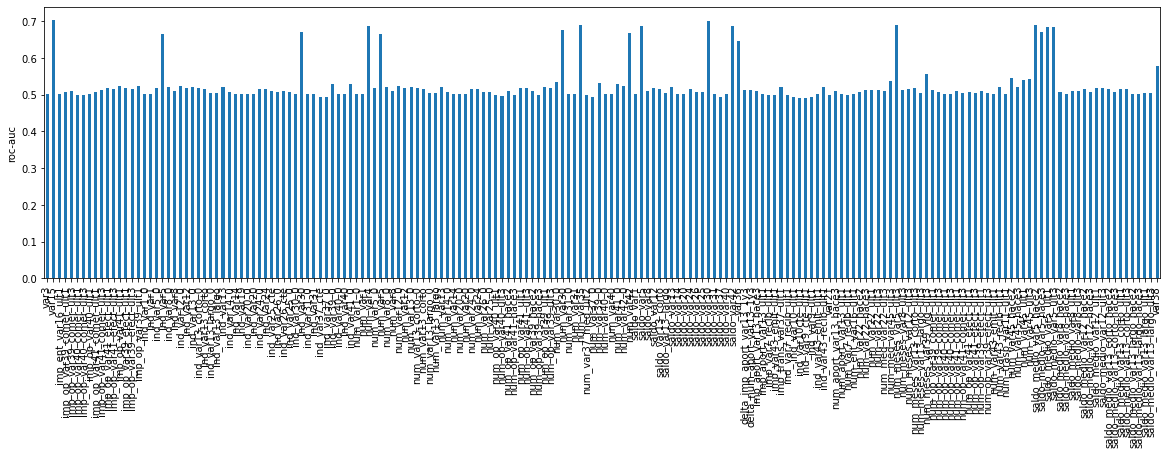

In [ ]:
pd.Series(sel.feature_performance_).plot.bar(figsize=(20,5))
plt.ylabel('roc-auc')
plt.show()

In [ ]:
len(sel.features_to_drop_)

156

In [ ]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

print('Number of variables after removing non important: ', X_train.shape[1])

Number of variables after removing non important:  28


# 3) 재귀적으로 기능 선택
- 이 방법은 모든 기능을 갖춘 모델을 구축하는 것으로 시작합니다.
- 그런 다음 모델에서 파생된 중요도에 따라 가장 중요한 것부터 가장 덜 중요한 것순으로 기능의 순위를 지정합니다.
- 그런 다음 가장 중요하지 않은 기능을 제거합니다.
- 새 모델을 학습하고 성능을 결정합니다.
- 성능 저하가 크면 기능을 유지하고 그렇지 않으면 제거합니다.
- 모든 기능이 검사될 때까지 3-5단계를 반복합니다.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['ID','TARGET'], axis=1),
    data['TARGET'],
    test_size=0.3,
    random_state=0)

# let's remove constant, quasi-constant and duplicates to speed things up

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)), # drops constand and quasi-constant altogether
    ('duplicated', DropDuplicateFeatures()),
])

# find features to remove
pipe.fit(X_train, y_train)

# remove variables

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)
test_pred = pipe.transform(test_pred)

ValueError: ignored

In [ ]:
rfe = RecursiveFeatureElimination(
    estimator = RandomForestClassifier(n_estimators=10,, max_depth=3,colsample_bytree=0.5, min_child_weight=3), # the model
    scoring="roc_auc", # the metric to determine model performance
    cv=3, # the cross-validation fold
    threshold = 0.04, 
)

rfe.fit(X_train, y_train)

In [ ]:
rfe.feature_importances_

In [ ]:
# plot of feature importance, derived from the Random Forests
pd.Series(rfe.feature_importances_).plot.bar(figsize=(20,5))
plt.ylabel('Feature importance derived from the random forests')
plt.show()

In [ ]:
# the number of features that will be dropped
len(rfe.features_to_drop_)

In [ ]:
X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)

print('Number of variables after removing non important: ', X_train.shape[1])

# 성능평가(AUC ROC)

# EDA (탐색적 데이터 분석)

### 일변량 분석

- 1)  var15는 연령일 가능성이 높다
  - 5~105 사이의 고유한 값을 가진다.
  - 그렇다면 주고객은 30세 미만이고 23세 미만 고객은 결코 불만족을 누르지 않는다.
  - 23세 미만 여부에 따라 새로운 특성을 넣을 수 있다. 
- 2)  num_var4는 고객이 은행에서 가지고 있는 은행 상품 수일 가능성이 높다.
  - 불만족한 고객은 은행 상품을 구매하지 않았고 2개 이상 상품을 구매한 고객은 거의 모두 만족을 골랐다. 
  - 'num_var4'이  6 이상인 고객은 모두 만족했다

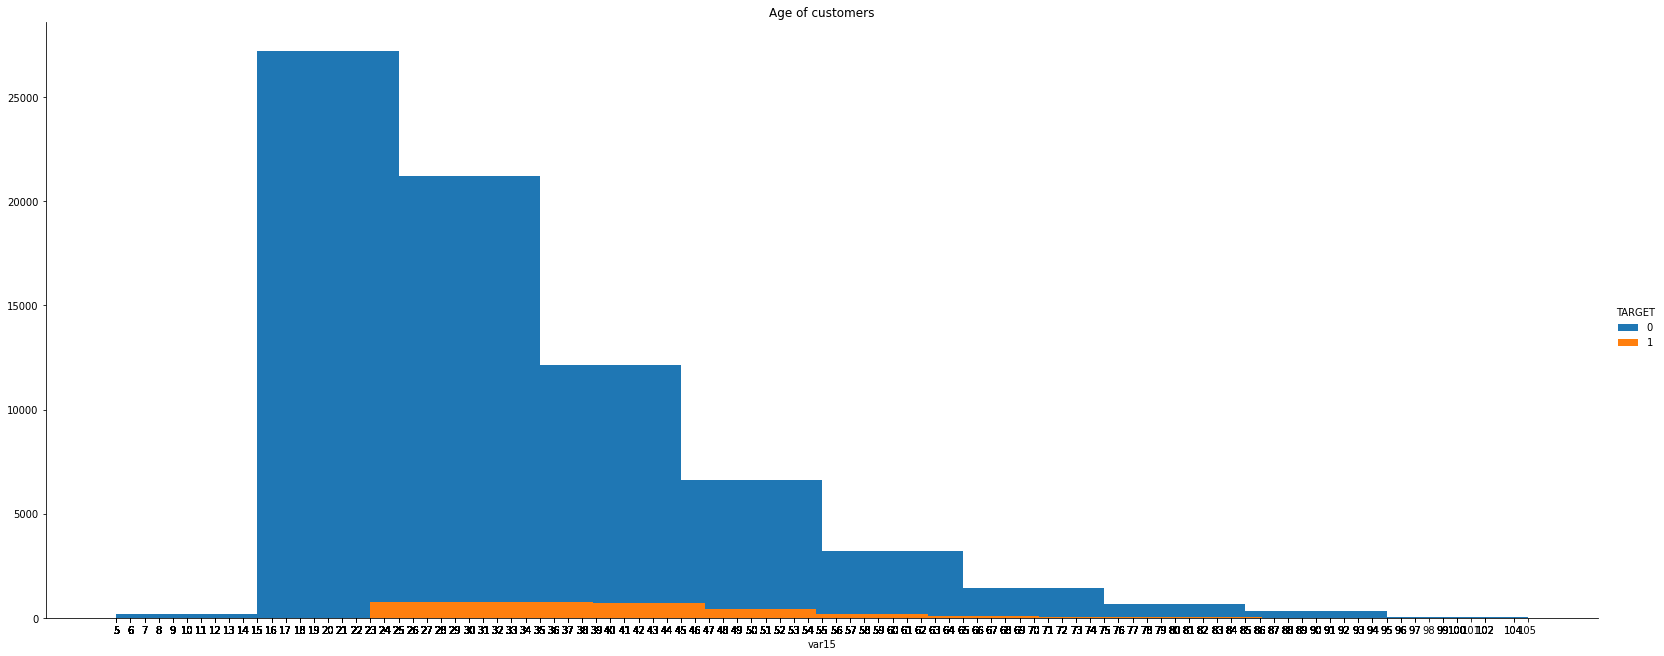

In [ ]:
#1) var15
counts, bins = np.histogram(train)
g = sns.FacetGrid(train, hue='TARGET', height=9, aspect=2.5).map(plt.hist, 'var15').add_legend()
g.set(xticks=train.var15)

plt.title('Age of customers')
plt.show()

In [ ]:
# 2) num_var4
train['num_var4'].value_counts()

1    38147
0    19528
2    12692
3     4377
4     1031
5      203
6       36
7        6
Name: num_var4, dtype: int64

In [ ]:
train.loc[train['TARGET']==0]['num_var4'].value_counts()

1    37455
0    17791
2    12359
3     4195
4      973
5      197
6       36
7        6
Name: num_var4, dtype: int64

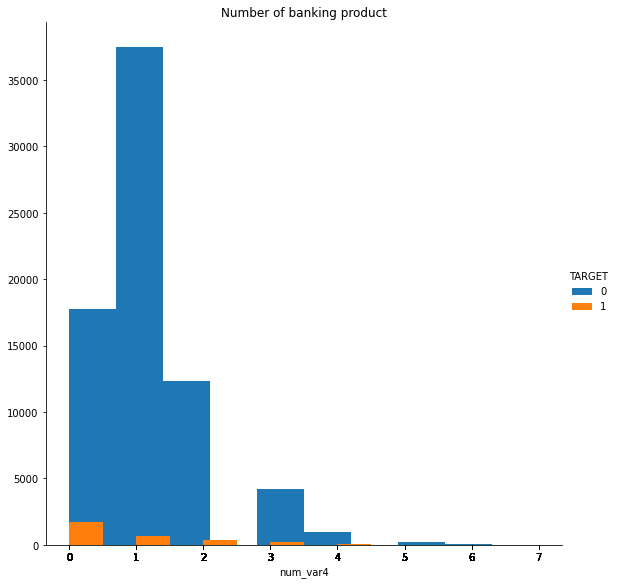

In [ ]:
g = sns.FacetGrid(train, hue='TARGET', height=8, aspect=1).map(plt.hist, 'num_var4').add_legend()
g.set(xticks=train.num_var4)

plt.title('Number of banking product')
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

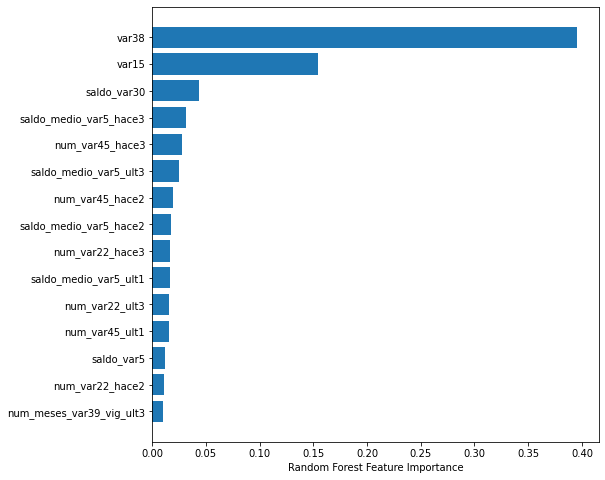

In [61]:
# decissiontree for feature importance:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# get importance
importance_dt = model.feature_importances_

# before feat engg
sorted_idx = importance_dt.argsort()[-15:]
plt.barh(X_train.columns[sorted_idx], importance_dt[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

# 데이터 보존 

In [ ]:
X_train = X_train1
X_test = X_test1
test_pred = test_pred1

# Feature Engineering

1) 연령에 따른 특성 추가 
- 'var15'는 연령을 나타내는 컬럼으로 그 중 23세 이하는 항상 만족하는 경향이 있음
- 23세 이하인지 판단하여 below_23 특성을 추가한다.
- 반대로 80세 이상은 대부분 불만족하는 경향이 있어 above_80 특성을 추가한다.

2) 상품 구매 수에 따른 특성 추가
- 'saldo_var30' 은 상품 구매수를 나타내는 특성으로 추정한다
- 구매한 상품 수가 0~3

In [ ]:
X_train['below_23']=X_train['var15'][X_train['var15'] <= 23]

In [ ]:
X_train['var15'][X_train['var15'] >= 80]

46194    83
7418     83
74953    89
19430    84
55704    86
         ..
50512    93
75583    82
40843    82
47449    99
49272    86
Name: var15, Length: 435, dtype: int64

In [ ]:
X_train['above_80']=X_train['var15'][X_train['var15'] >= 80]

In [ ]:
train[['saldo_var30','TARGET']][train['saldo_var30']<3] #

,saldo_var30,TARGET
0,0.0,0
5,0.0,0
8,0.0,0
11,0.0,0
16,0.0,0
...,...,...
75998,0.0,0
76007,0.0,1
76010,0.0,0
76015,0.0,0


In [ ]:
X_train.shape,X_test.shape, test_pred.shape

((53214, 109), (22806, 109), (75818, 182))

In [ ]:
i=0
for col in X_train.columns: #reomving all sparse features
    if np.percentile(train[col],99)==0:
        i+=1
        del X_train[col]
        del X_test[col]
        del test_pred[col]

In [ ]:
def add_feature_no_zeros(train=X_train,test=X_test):
    """
    Add feature which tells the no. of occurences of zeros,nonzeros across a datapoint
    """
    col = [k for k in train.columns if k!='TARGET']
    for df in [train,test]:
        df['no_zeros'] = (df.loc[:,col]==0).sum(axis=1).values
        df['no_nonzeros'] = (df.loc[:,col]!=0).sum(axis=1).values

In [ ]:
keywords = ['saldo' , 'ind', 'num', 'imp']
def add_feature_no_zeros_keyword(keyword,train=X_train,test=X_test):
    """
    Add feature which tells the no. of occurences of zeros,nonzeros across a datapoint
    for a specific keyword
    """
    col = [k for k in train.columns if keyword in k]
    for df in [train,test]:
        df['no_zeros_'+k] = (df.loc[:,col]==0).sum(axis=1).values
        df['no_nonzeros_'+k] = (df.loc[:,col]!=0).sum(axis=1).values

In [ ]:
def average_col(col,features,train=X_train,test=X_test):
  """
  Gets the average numerical values of features for each category in 'col' feature
  and add it as feature 
  """
  for df in [train,test]:
    unique_values = df[col].unique()
    
    for feature in features:
      avg_value=[]
      for value in unique_values:
        avg = df.loc[df[col]==value,feature].mean() #taking average for each category for feature col
        avg_value.append(avg)
      avg_dict = dict(zip(unique_values,avg_value))
      new_col = 'avg_'+col+'_'+feature
      df[new_col] = np.zeros(df.shape[0])
      for value in unique_values:
        df.loc[df[col]==value,new_col] = avg_dict[value]

features = [i for i in X_train.columns if ('saldo' in i) & ('no_zeros' not in i)]
features.extend([i for i in X_train.columns if ('imp' in i) & ('no_zeros' not in i)])
columns = [i for i in X_train.columns if (X_train[i].nunique()<=210) & (X_train[i].nunique()>50)] #categorical features

for col in tqdm(columns):
  average_col(col,features)

NameError: ignored

In [ ]:
def add_kmeans_cluster(ncluster=[2,4,6,8,10],train=X_train,test=X_test):
  for n in ncluster:
    print("for n=%i:"%(n))
    feat_name = 'Kmeans_'+str(n)
    kmeans = cluster.KMeans(n_clusters=n,n_jobs=-1,verbose=2,random_state=100)
    train[feat_name] = kmeans.fit_predict(X_train)
    test[feat_name] = kmeans.predict(X_test)

In [ ]:
def apply_log(train,test,column):
  """
  apply log transformation to all features in col variable
  """
  tr = train.copy()
  te = test.copy()
  for df in [tr,te]:
    for col in column:
      df.loc[df[col]>=0,col] = np.log(df.loc[df[col]>=0,col].values)
  
 return tr,te
features = [i for i in X_train.columns if (('saldo' in i)|('imp' in i)|(i=='var38'))&((X_train[i].values>=0).all())]
X_train_l,X_test_l = apply_log(X_train,X_test,features)

IndentationError: ignored

In [ ]:
X_train.shape,X_test.shape, test_pred.shape

((53214, 182), (22806, 182), (75818, 182))

# 모델링

In [ ]:

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## 랜덤포레스트

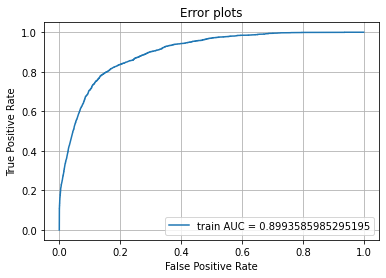

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(max_depth=13,n_estimators=150, min_samples_split=5 ,min_samples_leaf=2)
clf_rf.fit(X_train,y_train)
y_train_pred = clf_rf.predict_proba(X_train)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
y_pred = clf_rf.predict(test_pred)

plt.plot(train_fpr, train_tpr, label='train AUC = '+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Error plots")
plt.grid(True)
plt.show()

## XGBRF 분류기

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBRFClassifier

clf_xgbrf = XGBRFClassifier(missing=np.nan, max_depth=10,
n_estimators=200, learning_rate=0.025, nthread=4, subsample=0.8,
colsample_bytree=1)
xgb_mdl = CalibratedClassifierCV(clf_xgbrf, method='isotonic', cv=10)
xgb_mdl.fit(X_train,y_train)

y_train_pred = xgb_mdl.predict_proba(X_train)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)

plt.plot(train_fpr, train_tpr, label='train AUC = '+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Error plots")
plt.grid(True)
plt.show()

TypeError: ignored

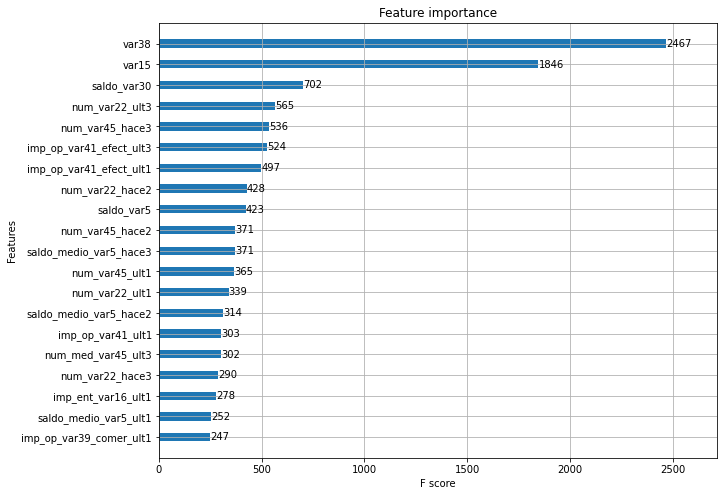

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(clf_xgbrf, ax=ax, max_num_features=20, height=0.4)
plt.show()

## XGB 분류기

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(missing=np.nan, max_depth=6,
n_estimators=350, learning_rate=0.025, nthread=4, subsample=0.95,
colsample_bytree=0.85, seed=4242)
clf_xgb.fit(X_train,y_train)
# xgb_mdl = CalibratedClassifierCV(clf_xgb, method='isotonic', cv=10)
# xgb_mdl.fit(X_train,y_train)

y_train_pred = xgb_mdl.predict_proba(X_train)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)

plt.plot(train_fpr, train_tpr, label='train AUC = '+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Error plots")
plt.grid(True)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/calibration.py:422: RuntimeWarning: invalid value encountered in true_divide
  mean_proba /= len(self.calibrated_classifiers_)


ValueError: ignored

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(missing=np.nan, max_depth=6,
n_estimators=350, learning_rate=0.025, nthread=4, subsample=0.95,
colsample_bytree=0.85, seed=4242)
clf_xgb.fit(X_train,y_train)
# xgb_mdl = CalibratedClassifierCV(clf_xgb, method='isotonic', cv=10)
# xgb_mdl.fit(X_train,y_train)
y_pred = xgb_mdl.predict(test)

KeyboardInterrupt: ignored

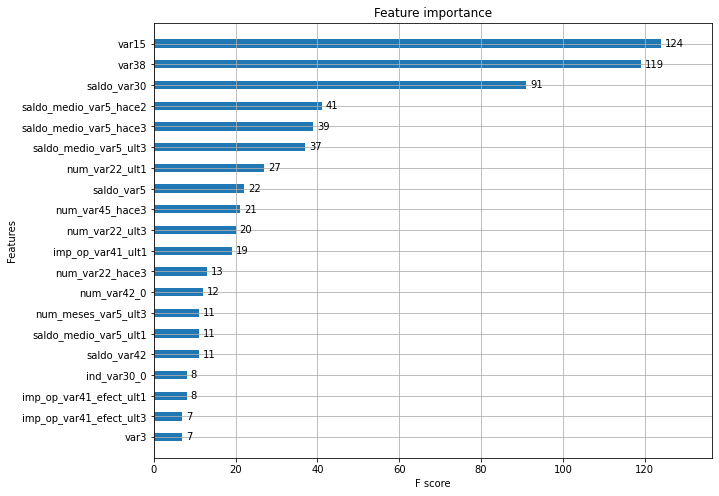

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(clf_xgb, ax=ax, max_num_features=20, height=0.4)
plt.show()

## LGBM 분류기

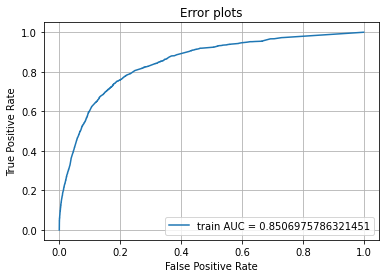

In [ ]:
from sklearn.utils import class_weight
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBRFClassifier

clf_lgbm = XGBRFClassifier(max_depth=10,
n_estimators=200,class_weight=None, learning_rate=0.1, nthread=4, subsample=0.6)
# clf_lgbm.fit(X_train,y_train)

xgb_mdl = CalibratedClassifierCV(clf_lgbm, method='isotonic', cv=10)
xgb_mdl.fit(X_train,y_train)

y_train_pred = xgb_mdl.predict_proba(X_train)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)

plt.plot(train_fpr, train_tpr, label='train AUC = '+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Error plots")
plt.grid(True)
plt.show()

## AdaBoost 분류기

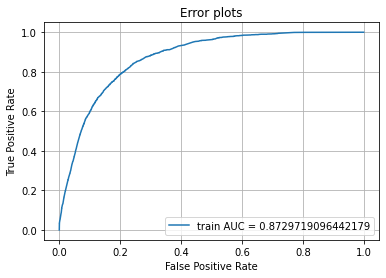

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf_adb = AdaBoostClassifier(n_estimators= 350, learning_rate=1)
# clf_adb.fit(X_train,y_train)

xgb_mdl = CalibratedClassifierCV(clf_adb, method='isotonic', cv=10)
xgb_mdl.fit(X_train,y_train)

y_train_pred = xgb_mdl.predict_proba(X_train)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)


plt.plot(train_fpr, train_tpr, label='train AUC = '+str(auc(train_fpr, train_tpr)))
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Error plots")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

clf_adb = AdaBoostClassifier(n_estimators= 350, learning_rate=1)
clf_adb.fit(X_train,y_train)

# xgb_mdl = CalibratedClassifierCV(clf_xgb, method='isotonic', cv=10)
# xgb_mdl.fit(X_train,y_train)

y_train_pred = clf_adb.predict(X_train)

# 교차검증

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5)
svm_scores = cross_val_score(clf_adb, X_train, y_train, cv=skf)
svm_scores.mean()

0.9601984538507725

## 캐글로 Export

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/DATA/sample_submission.csv")

In [ ]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      75818 non-null  int64
 1   TARGET  75818 non-null  int64
dtypes: int64(2)
memory usage: 1.2 MB


In [ ]:
y_pred #데이터 프레임으로  컬럼명을 'TARGET'

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
df = pd.DataFrame(data=y_pred, columns=['TARGET'])

In [ ]:
test['ID'].shape, df.shape

((75818,), (75818, 1))

In [ ]:
sample = pd.concat([test['ID'],df],axis=1)
# X_train = pd.concat([X_train,X_test],axis=0)

In [ ]:
sample['TARGET'].value_counts()

0    75808
1       10
Name: TARGET, dtype: int64

In [ ]:
train['TARGET'].value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

In [ ]:
sample = sample.astype({'TARGET':'float'})

In [ ]:
sample

,ID,TARGET
0,2,0.0
1,5,0.0
2,6,0.0
3,7,0.0
4,9,0.0
...,...,...
75813,151831,0.0
75814,151832,0.0
75815,151833,0.0
75816,151834,0.0


In [ ]:
sample.to_csv('Submisson1.csv', index=False)

In [69]:
X_train.shape, X_test.shape

((76020, 183), (75818, 183))

In [ ]:
train_id= train_df['ID']
test_id= test_df['ID']

In [71]:
test_rok = pd.concat([X_test,test_id], axis=1)

In [73]:
test_rok.to_csv('test_rok.csv')

In [76]:
X_train_rok = pd.concat([X_train,train_id,y_train], axis=1)

In [75]:
X_train_rok

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,...,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var33_hace2,saldo_medio_var44_hace2,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,ID,TARGET
0,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,1,0
1,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,3,0
2,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,4,0
3,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,195.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,8,0
4,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000,151829,0
76016,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000,151830,0
76017,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000,151835,0
76018,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000,151836,0


In [77]:
X_train_rok.to_csv('X_train_rok.csv')

---------

In [ ]:
sample.dropna(subset=["TARGET"], axis=0, inplace=True)

In [ ]:
sample = sample.astype({'TARGET':'int'})

In [ ]:
sample["TARGET"].fillna(0, inplace=True)